<div style="text-align: center; font-size: 32px; font-weight: bold;">
    COMP6713 Industry project
</div>
<div style="text-align: center; font-size: 16px;">
    Bowen Lu (z5472591)  
</div>
<div style="text-align: center; font-size: 16px;">
    **** 
</div>
<div style="text-align: center; font-size: 16px;">
    ********  
</div>
<div style="text-align: center; font-size: 16px;">
    **** 
</div>
<div style="text-align: center; font-size: 16px;">
    *****  
</div>

# Part 1. Introduction

This project is an industrial cooperation task of comp6713. The purpose is to help seek company develop an artificial intelligence system to extract information from job advertisements based on pre-trained LLMs on the market. The extraction tasks are mainly divided into extracting the salary of the job, the location of the job and the seniority required for the job. This project uses and fine-tunes a total of six different open source models, namely gemma3-1b, phi3.5-3.8b, llama3.2-1b, qwen2.5-1b, llama3.2-3b, qwen2.5-7b, and a closed source model chatgpt-4.1-mini. This project also forms an integrated system by using llama3.2-3b and qwen2.5-7b. The integrated system of this project is even close to the closed source model chatgpt4.1-mini from openai in some indicators.

# Part 2. Dataset

The dataset used in this project is provided by SEEK Company and contains the recruitment advertisement texts recently published on the SEEK platform. The dataset is divided into three parts:
Development set (labeled) : Used for model training and tuning, it contains manually labeled salary, job scheduling, and position level information.
Development set (unlabeled) : Can be used for unsupervised preprocessing or to assist in experimental design.
Test set (labeled) : Only for final performance evaluation, not for training or parameter tuning.
Furthermore, to further enhance the coverage and fineness of the training data, we independently annotated 80 new recruitment advertisement data. These supplementary samples cover some marginal situations that occur less frequently in the development set, such as special job types (such as part-time and internship positions), non-standard salary expressions (such as vague descriptions or the use of interval expressions), and multilingual mixed texts, aiming to enhance the generalization ability of the model on complex samples.
The data annotation follows the standards consistent with the official dataset, ensuring the uniformity and rigor of the overall annotation system.

In [ ]:
import pandas as pd
import os
files = {
    "seniority_dev": "/root/autodl-tmp/data/seniority_labelled_development_set.csv",
    "seniority_test": "/root/autodl-tmp/data/seniority_labelled_test_set.csv",
    "unlabelled_dev": "/root/autodl-tmp/data/unlabelled_development_set.csv",
    "work_arrangements_dev": "/root/autodl-tmp/data/work_arrangements_development_set.csv",
    "work_arrangements_test": "/root/autodl-tmp/data/work_arrangements_test_set.csv",
    "salary_dev": "/root/autodl-tmp/data/salary_labelled_development_set.csv",
    "salary_test": "/root/autodl-tmp/data/salary_labelled_test_set.csv",
}

# load all files into dataframes
dfs = {name: pd.read_csv(path) for name, path in files.items()}

# Basic analysis for each dataset: shape, data types, misssing value counts and show top 5 data
for name, df in dfs.items():
    print(f"=== File: {name} ===")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print("\nColumn Names:")
    print(df.columns.tolist())
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values per Column:")
    print(df.isnull().sum())
    print("\nFirst 5 Rows of Data:")
    print(df.head())
    print("=" * 80 + "\n")



=== File: seniority_dev ===
Rows: 2752, Columns: 7

Column Names:
['job_id', 'job_title', 'job_summary', 'job_ad_details', 'classification_name', 'subclassification_name', 'y_true']

Data Types:
job_id                     int64
job_title                 object
job_summary               object
job_ad_details            object
classification_name       object
subclassification_name    object
y_true                    object
dtype: object

Missing Values per Column:
job_id                    0
job_title                 0
job_summary               0
job_ad_details            0
classification_name       0
subclassification_name    0
y_true                    0
dtype: int64

First 5 Rows of Data:
     job_id                                          job_title  \
0  30765949   Electrical BIM modeller - Contract role - Sydney   
1  38536238                        Marketing Manager - Tourism   
2  29958739   Quality Coordinator Registered Nurse - Aged care   
3  33276107                  Nationa

## Part 2.1 Seniority datasets

=== Dataset: seniority_dev ===
Unique classification_name count: 30
Top 10 classification_name values:
classification_name
Information & Communication Technology    315
Trades & Services                         271
Healthcare & Medical                      240
Manufacturing, Transport & Logistics      195
Administration & Office Support           169
Sales                                     142
Hospitality & Tourism                     141
Accounting                                140
Construction                              113
Retail & Consumer Products                104
Name: count, dtype: int64


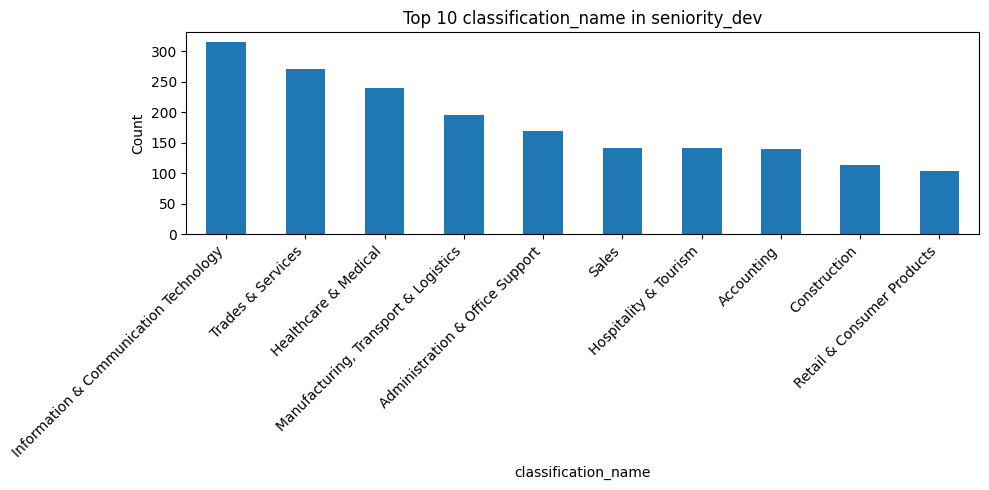


Unique subclassification_name count: 296
Top 10 subclassification_name values:
subclassification_name
Other                                  237
Management                              97
Administrative Assistants               80
Sales Representatives/Consultants       72
Developers/Programmers                  54
Chefs/Cooks                             43
Automotive Trades                       41
Warehousing, Storage & Distribution     38
Retail Assistants                       37
Nursing - Aged Care                     33
Name: count, dtype: int64


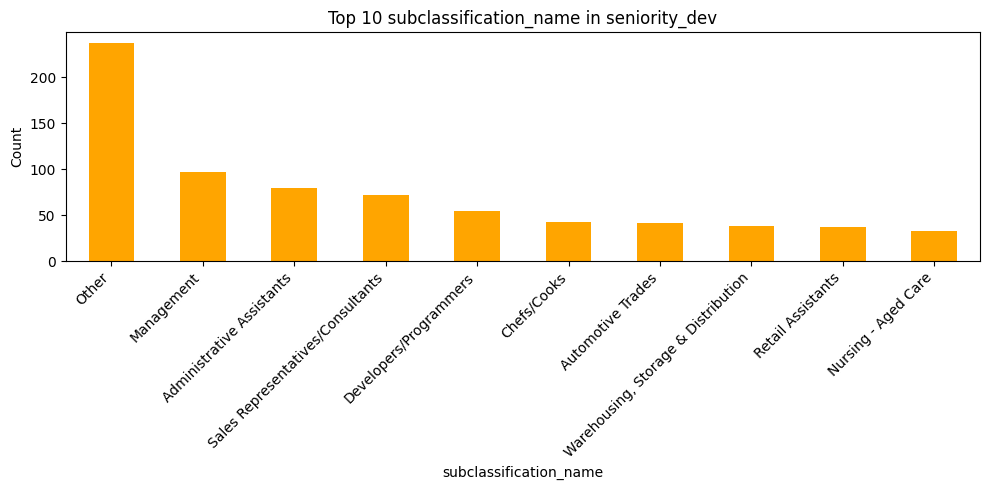


=== Dataset: seniority_test ===
Unique classification_name count: 30
Top 10 classification_name values:
classification_name
Trades & Services                         72
Information & Communication Technology    69
Healthcare & Medical                      61
Manufacturing, Transport & Logistics      50
Administration & Office Support           40
Sales                                     34
Hospitality & Tourism                     33
Accounting                                32
Retail & Consumer Products                29
Education & Training                      28
Name: count, dtype: int64


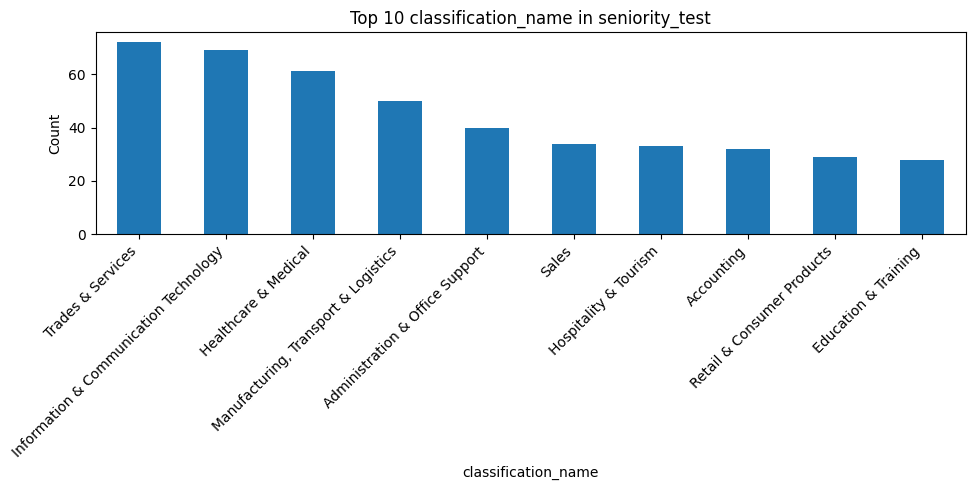


Unique subclassification_name count: 204
Top 10 subclassification_name values:
subclassification_name
Other                                    56
Management                               25
Administrative Assistants                19
Developers/Programmers                   16
Retail Assistants                        12
Warehousing, Storage & Distribution      12
Sales Representatives/Consultants        11
Management - Store                        9
Childcare & Outside School Hours Care     9
Building Trades                           9
Name: count, dtype: int64


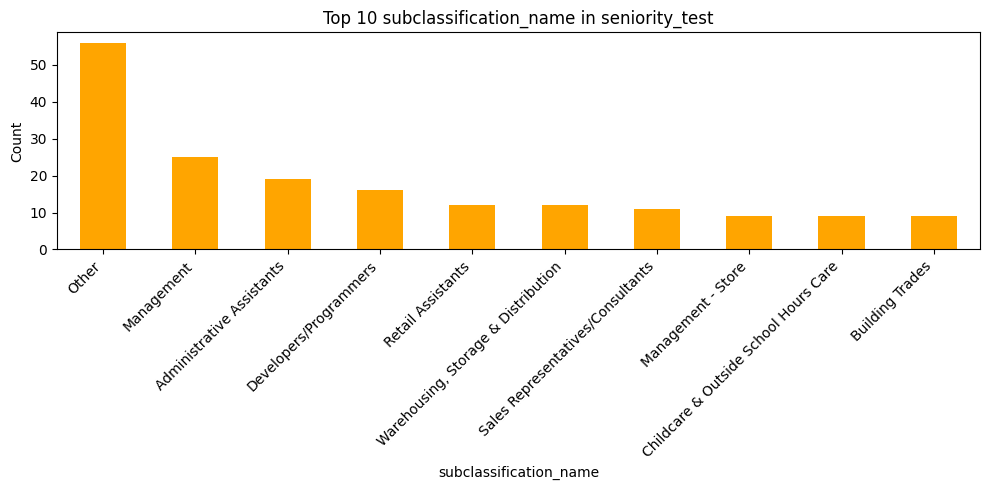

In [30]:
import matplotlib.pyplot as plt

# Seniority datasets
seniority_datasets = ["seniority_dev", "seniority_test"]

for name in seniority_datasets:
    df = dfs[name]
    print(f"=== Dataset: {name} ===")
    
    # Unique classification_name
    num_classifications = df['classification_name'].nunique()
    print(f"Unique classification_name count: {num_classifications}")
    top_classifications = df['classification_name'].value_counts().head(10)
    print("Top 10 classification_name values:")
    print(top_classifications)
    
    # Plot Top 10 classification_name
    plt.figure(figsize=(10, 5))
    top_classifications.plot(kind='bar')
    plt.title(f"Top 10 classification_name in {name}")
    plt.xlabel("classification_name")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Unique subclassification_name
    num_subclassifications = df['subclassification_name'].nunique()
    print(f"\nUnique subclassification_name count: {num_subclassifications}")
    top_subclassifications = df['subclassification_name'].value_counts().head(10)
    print("Top 10 subclassification_name values:")
    print(top_subclassifications)
    
    # Plot Top 10 subclassification_name
    plt.figure(figsize=(10, 5))
    top_subclassifications.plot(kind='bar', color='orange')
    plt.title(f"Top 10 subclassification_name in {name}")
    plt.xlabel("subclassification_name")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("=" * 80 + "\n")

## Part 2.2 Work arragements datasets

=== Dataset: work_arrangements_dev ===
Unique y_true count: 3
y_true value counts:
y_true
OnSite    44
Remote    34
Hybrid    21
Name: count, dtype: int64


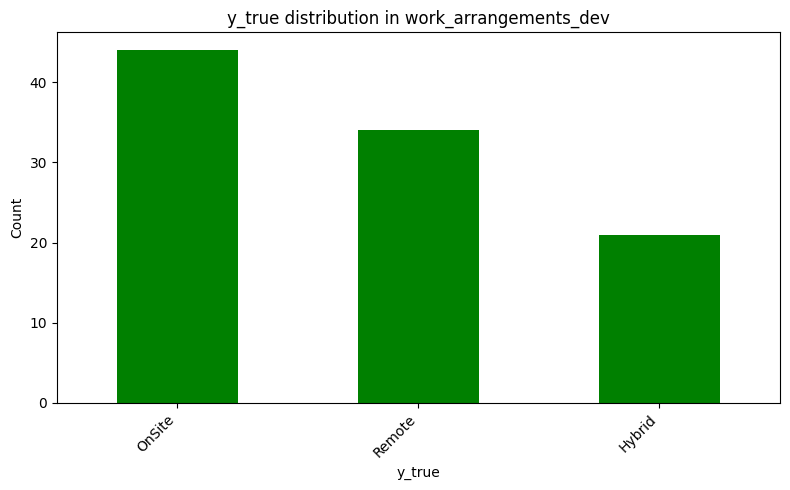


=== Dataset: work_arrangements_test ===
Unique y_true count: 3
y_true value counts:
y_true
OnSite    46
Hybrid    27
Remote    26
Name: count, dtype: int64


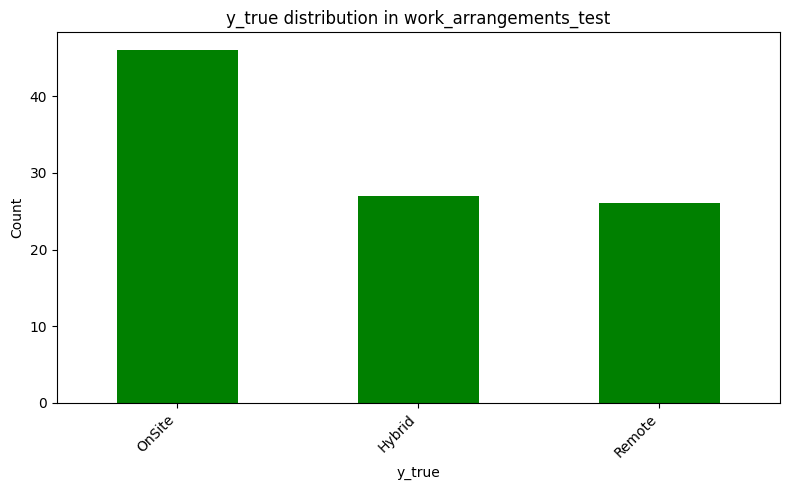

In [32]:
# Work arrangements datasets
work_arrangements_datasets = ["work_arrangements_dev", "work_arrangements_test"]

for name in work_arrangements_datasets:
    df = dfs[name]
    print(f"=== Dataset: {name} ===")
    
    # Unique y_true values
    num_y_true = df['y_true'].nunique()
    print(f"Unique y_true count: {num_y_true}")
    y_true_counts = df['y_true'].value_counts()
    print("y_true value counts:")
    print(y_true_counts)
    
    # Plot y_true distribution
    plt.figure(figsize=(8, 5))
    y_true_counts.plot(kind='bar', color='green')
    plt.title(f"y_true distribution in {name}")
    plt.xlabel("y_true")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("=" * 80 + "\n")

<font size="4"><font color="red"></font>

## Part 2.3 Salary datasets

=== Dataset: salary_dev ===
Unique nation_short_desc count: 8
Top 10 nation_short_desc values:
nation_short_desc
AUS    454
HK     355
MY     326
SG     324
PH     256
TH     214
NZ     213
ID     125
Name: count, dtype: int64


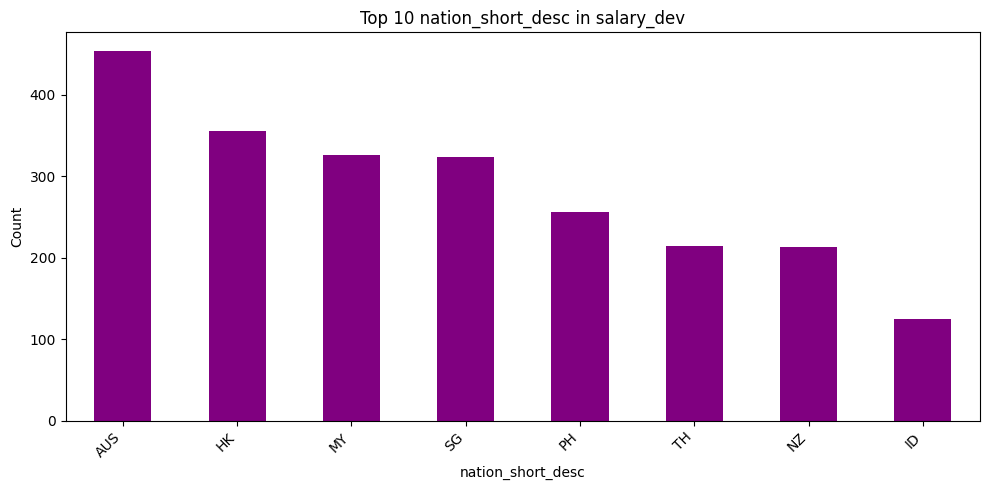


=== Dataset: salary_test ===
Unique nation_short_desc count: 8
Top 10 nation_short_desc values:
nation_short_desc
AUS    102
MY      93
SG      90
HK      79
NZ      64
PH      62
TH      46
ID      31
Name: count, dtype: int64


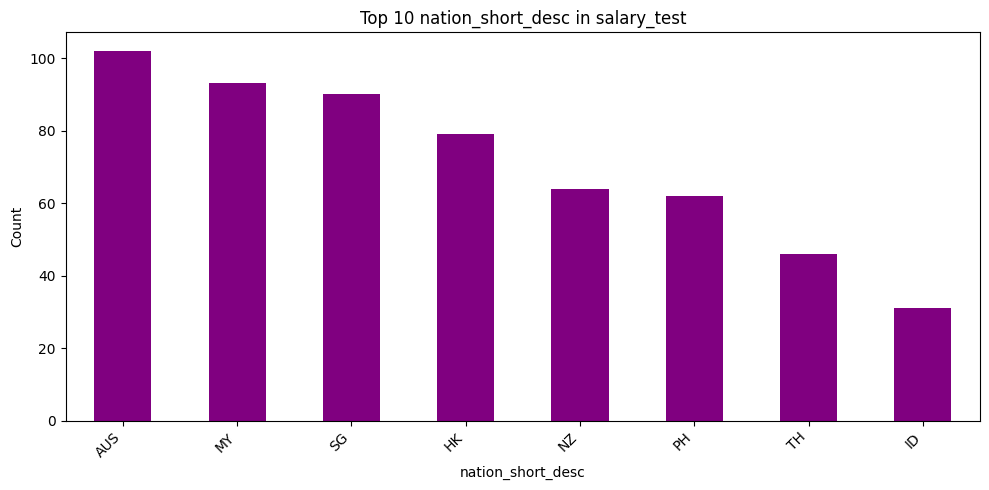

In [34]:
# Salary datasets
salary_datasets = ["salary_dev", "salary_test"]

for name in salary_datasets:
    df = dfs[name]
    print(f"=== Dataset: {name} ===")
    
    # Unique nation_short_desc values
    num_nations = df['nation_short_desc'].nunique()
    print(f"Unique nation_short_desc count: {num_nations}")
    nation_counts = df['nation_short_desc'].value_counts()
    print("Top 10 nation_short_desc values:")
    print(nation_counts.head(10))
    
    # Plot nation_short_desc
    plt.figure(figsize=(10, 5))
    nation_counts.plot(kind='bar', color='purple')
    plt.title(f"Top 10 nation_short_desc in {name}")
    plt.xlabel("nation_short_desc")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("=" * 80 + "\n")

# Part 3. Methods

## Part 3.1 pre-neural solution

## Part 3.2 LLM methods

For each model, we tried few-shots (10 examples) and zero-shots. For the salary dataset, we also tried removing HTML tags and not removing them.

<span style="color: red;">
Since many codes are repeated, this notebook only shows the code for one dataset each model. For detailed code, please go to the detailed folder to see the detailed ipynb.
</span>

In [ ]:
import pandas as pd
import torch
from transformers import pipeline, AutoTokenizer, StoppingCriteria, StoppingCriteriaList
from transformers import AutoTokenizer, BitsAndBytesConfig, Gemma3ForCausalLM
from bs4 import BeautifulSoup

### Part 3.2.1 Gemma-1b-instruct

In [ ]:
# load model from local
model_name = "/root/autodl-tmp/gemma-3-1b-it"

model = Gemma3ForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  
    device_map="auto",          
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def clean_html(raw_html):
    if pd.isna(raw_html):
        return ""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text(separator=" ", strip=True)

In [ ]:
train_df = pd.read_csv("/root/autodl-tmp/data/salary_labelled_development_set.csv")  

def row_to_text(row, include_label=True):
    job_title = row["job_title"]
    job_details = clean_html(row["job_ad_details"])
    location = row["nation_short_desc"]

    base_text = f"Job Title: {job_title}\nJob Description: {job_details}\nLocation: {location}"
    if include_label:
        base_text += f"\ny_true: {row['y_true']}"
    return base_text

In [ ]:
# use first 10 data in train set as few-shot
shots = "\n\n".join([f"example{i+1}：\n{row_to_text(train_df.iloc[i])}" for i in range(10)])

In [ ]:
test_df = pd.read_csv("/root/autodl-tmp/data/salary_labelled_test_set.csv")


test_df["predicted"] = ""
test_df["true_label"] = test_df["y_true"].astype(str)
results = []
correct=0

for i, row in test_df.iterrows():
    query = f"query：\n{row_to_text(row, include_label=False)}\nyour_predict：y_true ="

    user_prompt = (
        "You are a classification assistant. Below are some job descriptions along with their corresponding salaries (y_true)：\n\n"
        "Please only give me answer, no more other things.The stuctrue shold be like 100-200-AUS-MONTHLY.(No commas are required between numbers)"
        "If you think there is no mention of salary, please give me 0-0-None-None."
        # f"{shots}\n\n{query}"
        f"{query}"
    )

    messages = [
        # {"role": "system", "content": ""},
        {"role": "user", "content": user_prompt}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    outputs = model.generate(
        **model_inputs,
        max_new_tokens=30,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    gen_ids = outputs[0][model_inputs["input_ids"].shape[-1]:]
    prediction = tokenizer.decode(gen_ids, skip_special_tokens=True).strip().split("\n")[0]

    results.append({
        "index": i,
        "predicted": prediction,
        "true_label": str(row["y_true"])
    })
    if prediction == str(row["y_true"]):
        correct+=1
    # save
    if (i + 1) % 100 == 0:
        checkpoint_df = pd.DataFrame(results)
        filename = f"gemma/gemma-1b-salary_predictions_nohtml_zeroshot.csv"
        checkpoint_df.to_csv(filename, index=False)
        print(f"{i+1},save result to：{filename}")
    number=i
    # if i ==220:
    #     break


filename = f"gemma/gemma-1b-salary_predictions_nohtml_zeroshot.csv"
final_df = pd.DataFrame(results)
final_df.to_csv(filename, index=False)

100,save result to：gemma/gemma-1b-salary_predictions_nohtml_zeroshot.csv
200,save result to：gemma/gemma-1b-salary_predictions_nohtml_zeroshot.csv
300,save result to：gemma/gemma-1b-salary_predictions_nohtml_zeroshot.csv
400,save result to：gemma/gemma-1b-salary_predictions_nohtml_zeroshot.csv
500,save result to：gemma/gemma-1b-salary_predictions_nohtml_zeroshot.csv


In [ ]:

correct

2

In [ ]:
number

566

In [ ]:
accuracy=correct/number


In [ ]:
print(f"accuracy：{accuracy:.2%}")
print(f"save result to：{filename}")

accuracy：0.35%
save result to：gemma/gemma-1b-salary_predictions_nohtml_zeroshot.csv


### Part 3.2.2 phi-3.8b-instruct

In [ ]:
# load model from local
model_name = "/root/autodl-tmp/phi-3-mini-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def clean_html(raw_html):
    if pd.isna(raw_html):
        return ""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text(separator=" ", strip=True)

In [ ]:
train_df = pd.read_csv("/root/autodl-tmp/data/salary_labelled_development_set.csv")  

def row_to_text(row, include_label=True):
    job_title = row["job_title"]
    job_details = clean_html(row["job_ad_details"])
    location = row["nation_short_desc"]

    base_text = f"Job Title: {job_title}\nJob Description: {job_details}\nLocation: {location}"
    if include_label:
        base_text += f"\ny_true: {row['y_true']}"
    return base_text

In [ ]:
# use first 10 data in train set as few-shot
shots = "\n\n".join([f"example{i+1}：\n{row_to_text(train_df.iloc[i])}" for i in range(10)])

In [ ]:
test_df = pd.read_csv("/root/autodl-tmp/data/salary_labelled_test_set.csv")


test_df["predicted"] = ""
test_df["true_label"] = test_df["y_true"].astype(str)
results = []
correct=0

for i, row in test_df.iterrows():
    query = f"query：\n{row_to_text(row, include_label=False)}\nyour_predict：y_true ="

    user_prompt = (
        "You are a classification assistant. Below are some job descriptions along with their corresponding salaries (y_true)：\n\n"
        "Please only give me answer, no more other things.The stuctrue shold be like 100-200-AUS-MONTHLY.(No commas are required between numbers)"
        "If you think there is no mention of salary, please give me 0-0-None-None."
        # f"{shots}\n\n{query}"
        f"{query}"
    )

    messages = [
        # {"role": "system", "content": ""},
        {"role": "user", "content": user_prompt}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    outputs = model.generate(
        **model_inputs,
        max_new_tokens=30,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    gen_ids = outputs[0][model_inputs["input_ids"].shape[-1]:]
    prediction = tokenizer.decode(gen_ids, skip_special_tokens=True).strip().split("\n")[0]

    results.append({
        "index": i,
        "predicted": prediction,
        "true_label": str(row["y_true"])
    })
    if prediction == str(row["y_true"]):
        correct+=1
    # save
    if (i + 1) % 100 == 0:
        checkpoint_df = pd.DataFrame(results)
        filename = f"phi/phi-1b-salary_predictions_nohtml_zeroshot.csv"
        checkpoint_df.to_csv(filename, index=False)
        print(f"{i+1},save result to：{filename}")
    number=i
    # if i ==220:
    #     break


filename = f"phi/phi-1b-salary_predictions_nohtml_zeroshot.csv"
final_df = pd.DataFrame(results)
final_df.to_csv(filename, index=False)

100,save result to：phi/phi-1b-salary_predictions_nohtml_zeroshot.csv
200,save result to：phi/phi-1b-salary_predictions_nohtml_zeroshot.csv
300,save result to：phi/phi-1b-salary_predictions_nohtml_zeroshot.csv
400,save result to：phi/phi-1b-salary_predictions_nohtml_zeroshot.csv
500,save result to：phi/phi-1b-salary_predictions_nohtml_zeroshot.csv


In [ ]:

correct

0

In [ ]:
number

566

In [ ]:
accuracy=correct/number


In [ ]:
print(f"accuracy：{accuracy:.2%}")
print(f"save result to：{filename}")

accuracy：0.00%
save result to：phi/phi-1b-salary_predictions_nohtml_zeroshot.csv


### Part 3.2.3 Llama3.2-1b-instruct

In [ ]:
# load model from local
model_name = "/root/autodl-tmp/llama-3.2-1b-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def clean_html(raw_html):
    if pd.isna(raw_html):
        return ""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text(separator=" ", strip=True)

In [ ]:
train_df = pd.read_csv("/root/autodl-tmp/data/salary_labelled_development_set.csv")  

def row_to_text(row, include_label=True):
    job_title = row["job_title"]
    job_details = clean_html(row["job_ad_details"])
    # job_details = row["job_ad_details"]
    location = row["nation_short_desc"]

    base_text = f"Job Title: {job_title}\nJob Description: {job_details}\nLocation: {location}"
    if include_label:
        base_text += f"\ny_true: {row['y_true']}"
    return base_text

In [ ]:
# use first 10 data in train set as few-shot
shots = "\n\n".join([f"example{i+1}：\n{row_to_text(train_df.iloc[i])}" for i in range(10)])

In [ ]:
test_df = pd.read_csv("/root/autodl-tmp/data/salary_labelled_test_set.csv")


test_df["predicted"] = ""
test_df["true_label"] = test_df["y_true"].astype(str)
results = []
correct=0

for i, row in test_df.iterrows():
    query = f"query：\n{row_to_text(row, include_label=False)}\nyour_predict：y_true ="

    user_prompt = (
        "You are a classification assistant. Below are some job descriptions along with their corresponding salaries (y_true)：\n\n"
        "Please only give me answer, no more other things.The stuctrue shold be like 100-200-AUS-MONTHLY.(No commas are required between numbers)"
        "If you think there is no mention of salary, please give me 0-0-None-None."
        "Do not give me things like y_true = 0-0-None-None, only give me answer, like 0-0-None-None"
        # f"{shots}\n\n{query}"
        f"{query}"
    )

    messages = [
        # {"role": "system", "content": ""},
        {"role": "user", "content": user_prompt}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    outputs = model.generate(
        **model_inputs,
        max_new_tokens=30,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    gen_ids = outputs[0][model_inputs["input_ids"].shape[-1]:]
    prediction = tokenizer.decode(gen_ids, skip_special_tokens=True).strip().split("\n")[0]

    results.append({
        "index": i,
        "predicted": prediction,
        "true_label": str(row["y_true"])
    })
    if prediction == str(row["y_true"]):
        correct+=1
    # save
    if (i + 1) % 100 == 0:
        checkpoint_df = pd.DataFrame(results)
        filename = f"llama/llama-1b-salary_predictions_nohtml_zeroshot.csv"
        checkpoint_df.to_csv(filename, index=False)
        print(f"{i+1},save result to：{filename}")
    number=i
    # if i ==220:
    #     break


filename = f"llama/llama-1b-salary_predictions_nohtml_zeroshot.csv"
final_df = pd.DataFrame(results)
final_df.to_csv(filename, index=False)

100,save result to：llama/llama-1b-salary_predictions_nohtml_zeroshot.csv
200,save result to：llama/llama-1b-salary_predictions_nohtml_zeroshot.csv
300,save result to：llama/llama-1b-salary_predictions_nohtml_zeroshot.csv
400,save result to：llama/llama-1b-salary_predictions_nohtml_zeroshot.csv
500,save result to：llama/llama-1b-salary_predictions_nohtml_zeroshot.csv


In [ ]:

correct

95

In [ ]:
number

566

In [ ]:
accuracy=correct/number


In [ ]:
print(f"accuracy：{accuracy:.2%}")
print(f"save result to：{filename}")

accuracy：16.78%
save result to：llama/llama-1b-salary_predictions_nohtml_zeroshot.csv


### Part 3.2.4 Qwen2.5-1b-instruct


In [ ]:
# load model from local
model_name = "/root/autodl-tmp/qwen-2.5-1.5b-instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def clean_html(raw_html):
    if pd.isna(raw_html):
        return ""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text(separator=" ", strip=True)

In [ ]:
train_df = pd.read_csv("/root/autodl-tmp/data/salary_labelled_development_set.csv")  

def row_to_text(row, include_label=True):
    job_title = row["job_title"]
    job_details = clean_html(row["job_ad_details"])
    location = row["nation_short_desc"]

    base_text = f"Job Title: {job_title}\nJob Description: {job_details}\nLocation: {location}"
    if include_label:
        base_text += f"\ny_true: {row['y_true']}"
    return base_text

In [ ]:
# use first 10 data in train set as few-shot
shots = "\n\n".join([f"example{i+1}：\n{row_to_text(train_df.iloc[i])}" for i in range(10)])

In [ ]:
test_df = pd.read_csv("/root/autodl-tmp/data/salary_labelled_test_set.csv")


test_df["predicted"] = ""
test_df["true_label"] = test_df["y_true"].astype(str)
results = []
correct=0

for i, row in test_df.iterrows():
    query = f"query：\n{row_to_text(row, include_label=False)}\nyour_predict：y_true ="

    user_prompt = (
        "You are a classification assistant. Below are some job descriptions along with their corresponding salaries (y_true)：\n\n"
        "Please only give me answer, no more other things.The stuctrue shold be like 100-200-AUS-MONTHLY.(No commas are required between numbers)"
        "If you think there is no mention of salary, please give me 0-0-None-None."
        # f"{shots}\n\n{query}"
        f"{query}"
    )

    messages = [
        # {"role": "system", "content": ""},
        {"role": "user", "content": user_prompt}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    outputs = model.generate(
        **model_inputs,
        max_new_tokens=30,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    gen_ids = outputs[0][model_inputs["input_ids"].shape[-1]:]
    prediction = tokenizer.decode(gen_ids, skip_special_tokens=True).strip().split("\n")[0]

    results.append({
        "index": i,
        "predicted": prediction,
        "true_label": str(row["y_true"])
    })
    if prediction == str(row["y_true"]):
        correct+=1
    # save
    if (i + 1) % 100 == 0:
        checkpoint_df = pd.DataFrame(results)
        filename = f"qwen/qwen-1b-salary_predictions_nohtml_zeroshot.csv"
        checkpoint_df.to_csv(filename, index=False)
        print(f"{i+1},save result to：{filename}")
    number=i
    # if i ==220:
    #     break


filename = f"qwen/qwen-1b-salary_predictions_nohtml_zeroshot.csv"
final_df = pd.DataFrame(results)
final_df.to_csv(filename, index=False)

100,save result to：qwen/qwen-1b-salary_predictions_nohtml_zeroshot.csv
200,save result to：qwen/qwen-1b-salary_predictions_nohtml_zeroshot.csv
300,save result to：qwen/qwen-1b-salary_predictions_nohtml_zeroshot.csv
400,save result to：qwen/qwen-1b-salary_predictions_nohtml_zeroshot.csv
500,save result to：qwen/qwen-1b-salary_predictions_nohtml_zeroshot.csv


In [ ]:

correct

129

In [ ]:
number

566

In [ ]:
accuracy=correct/number


In [ ]:
print(f"accuracy：{accuracy:.2%}")
print(f"save result to：{filename}")

accuracy：22.79%
save result to：qwen/qwen-1b-salary_predictions_nohtml_zeroshot.csv


### Part 3.2.5 Llama3.2-3b-instruct

In [ ]:
# load model from local
model_name = "/root/autodl-tmp/Llama-3.2-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def clean_html(raw_html):
    if pd.isna(raw_html):
        return ""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text(separator=" ", strip=True)

In [ ]:
train_df = pd.read_csv("/root/autodl-tmp/data/salary_labelled_development_set.csv")  

def row_to_text(row, include_label=True):
    job_title = row["job_title"]
    # job_details = clean_html(row["job_ad_details"])
    job_details = row["job_ad_details"]
    location = row["nation_short_desc"]

    base_text = f"Job Title: {job_title}\nJob Description: {job_details}\nLocation: {location}"
    if include_label:
        base_text += f"\ny_true: {row['y_true']}"
    return base_text

In [ ]:
# use first 10 data in train set as few-shot
shots = "\n\n".join([f"example{i+1}：\n{row_to_text(train_df.iloc[i])}" for i in range(10)])

In [ ]:
test_df = pd.read_csv("/root/autodl-tmp/data/salary_labelled_test_set.csv")


test_df["predicted"] = ""
test_df["true_label"] = test_df["y_true"].astype(str)
results = []
correct=0

for i, row in test_df.iterrows():
    query = f"query：\n{row_to_text(row, include_label=False)}\nyour_predict：y_true ="

    user_prompt = (
        "You are a classification assistant. Below are some job descriptions along with their corresponding salaries (y_true)：\n\n"
        "Please only give me answer, no more other things.The stuctrue shold be like 100-200-AUS-MONTHLY.(No commas are required between numbers)"
        "If you think there is no mention of salary, please give me 0-0-None-None."
        "Do not give me things like y_true = 0-0-None-None, only give me answer, like 0-0-None-None"
        f"{shots}\n\n{query}"
    )

    messages = [
        # {"role": "system", "content": ""},
        {"role": "user", "content": user_prompt}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    outputs = model.generate(
        **model_inputs,
        max_new_tokens=30,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    gen_ids = outputs[0][model_inputs["input_ids"].shape[-1]:]
    prediction = tokenizer.decode(gen_ids, skip_special_tokens=True).strip().split("\n")[0]

    results.append({
        "index": i,
        "predicted": prediction,
        "true_label": str(row["y_true"])
    })
    if prediction == str(row["y_true"]):
        correct+=1
    # save
    if (i + 1) % 100 == 0:
        checkpoint_df = pd.DataFrame(results)
        filename = f"llama3/llama-3b-salary_predictions.csv"
        checkpoint_df.to_csv(filename, index=False)
        print(f"{i+1},save result to：{filename}")
    number=i
    # if i ==220:
    #     break


filename = f"llama3/llama-3b-salary_predictions.csv"
final_df = pd.DataFrame(results)
final_df.to_csv(filename, index=False)

In [ ]:

correct

227

In [ ]:
number

566

In [ ]:
accuracy=correct/number


In [ ]:
print(f"accuracy：{accuracy:.2%}")
print(f"save result to：{filename}")

accuracy：40.11%
save result to：llama3/llama-3b-salary_predictions.csv


### Part 3.2.6 Qwen2.5-7b-instruct

In [ ]:
# load model from local
model_name = "/root/Qwen2.5-7B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
train_df = pd.read_csv("/root/autodl-tmp/data/seniority_labelled_development_set.csv")  

def row_to_text(row, include_label=True):
    base = (
        f"Job Title: {row['job_title']}\n"
        f"Summary: {row['job_summary']}\n"
        f"Details: {row['job_ad_details']}\n"
        f"classification_name: {row['classification_name']}\n"
        f"subclassification_name: {row['subclassification_name']}\n"
        # f"seniority: {row['y_true']}"
    )
    return base + (f"\nLabel: y_true = {row['y_true']}" if include_label else "")

In [ ]:
# use first 10 data in train set as few-shot
shots = "\n\n".join([f"example{i+1}：\n{row_to_text(train_df.iloc[i])}" for i in range(10)])

In [ ]:
test_df = pd.read_csv("/root/autodl-tmp/data/seniority_labelled_test_set.csv")


test_df["predicted"] = ""
test_df["true_label"] = test_df["y_true"].astype(str)
results = []
correct=0

for i, row in test_df.iterrows():
    query = f"query：\n{row_to_text(row, include_label=False)}\nyour_predict：y_true ="

    user_prompt = (
        "You are a classification assistant. Below are some job descriptions along with their corresponding seniorities (y_true)：\n\n"
        "Please only give me answer, no more other things,like experienced, intermediate, senior, entry level, assistant, lead, head, junior and so on.)"
         "Do not give me things like y_true = experienced, only give me answer, like experienced,no more other things"
        f"{shots}\n\n{query}"
        # f"{query}"
    )

    messages = [
        # {"role": "system", "content": ""},
        {"role": "user", "content": user_prompt}
    ]

    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    outputs = model.generate(
        **model_inputs,
        max_new_tokens=30,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    gen_ids = outputs[0][model_inputs["input_ids"].shape[-1]:]
    prediction = tokenizer.decode(gen_ids, skip_special_tokens=True).strip().split("\n")[0]

    results.append({
        "index": i,
        "predicted": prediction,
        "true_label": str(row["y_true"])
    })
    if prediction == str(row["y_true"]):
        correct+=1
    # save
    if (i + 1) % 100 == 0:
        checkpoint_df = pd.DataFrame(results)
        filename = f"qwen7/qwen-7b-senority_predictions.csv"
        checkpoint_df.to_csv(filename, index=False)
        print(f"{i+1},save result to：{filename}")
    number=i
    # if i ==220:
    #     break


filename = f"qwen7/qwen-7b-senority_predictions.csv"
final_df = pd.DataFrame(results)
final_df.to_csv(filename, index=False)

100,save result to：qwen7/qwen-7b-senority_predictions.csv
200,save result to：qwen7/qwen-7b-senority_predictions.csv
300,save result to：qwen7/qwen-7b-senority_predictions.csv
400,save result to：qwen7/qwen-7b-senority_predictions.csv
500,save result to：qwen7/qwen-7b-senority_predictions.csv
600,save result to：qwen7/qwen-7b-senority_predictions.csv


In [ ]:

correct

321

In [ ]:
number

688

In [ ]:
accuracy=correct/number


In [ ]:
print(f"accuracy：{accuracy:.2%}")
print(f"save result to：{filename}")

accuracy：46.66%
save result to：qwen7/qwen-7b-senority_predictions.csv


### Part 3.2.7 Chatgpt-4.1-mini

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
from openai import OpenAI

In [ ]:
client = OpenAI(api_key="your_key")


In [ ]:
train_df = pd.read_csv("./data/work_arrangements_development_set.csv")

In [ ]:
def row_to_text(row, include_label=True):
    base = (
        f"job_ad: {row['job_ad']}\n"
        # f"work arrangement: {row['y_true']}"
    )
    return base + (f"\nLabel: y_true = {row['y_true']}" if include_label else "")

In [ ]:
shots = "\n\n".join([f"example{i+1}：\n{row_to_text(train_df.iloc[i])}" for i in range(10)])

In [ ]:
test_df = pd.read_csv("./data/work_arrangements_test_set.csv")

test_df["predicted"] = ""
test_df["true_label"] = test_df["y_true"].astype(str)
results = []
correct = 0

for i, row in test_df.iterrows():
    query = f"query：\n{row_to_text(row, include_label=False)}\nyour_predict：y_true ="

    user_prompt = (
        "You are a classification assistant. Below are some job descriptions along with their corresponding work arrangement (y_true)：\n\n"
        "Please only give me answer, no more other things,you should choose a word in OnSite, Remote and Hybrid as answer.)"
        # f"{shots}\n\n{query}"
        f"{query}"
    )

    messages = [
        {"role": "user", "content": user_prompt}
    ]

    response = client.chat.completions.create(
        model="ft:gpt-4.1-mini-2025-04-14:personal:6713:BQuQ64ON",
        # model='gpt-4.1-mini',
        messages=messages,
        max_tokens=30,
        temperature=0.7
    )

    prediction = response.choices[0].message.content.strip().split("\n")[0]


    results.append({
        "index": i,
        "predicted": prediction,
        "true_label": str(row["y_true"])
    })
    if prediction == str(row["y_true"]):
        correct += 1
    if (i + 1) % 100 == 0:
        checkpoint_df = pd.DataFrame(results)
        filename = f"gpt4mini/gpt-4.1-mini-work_predictions_zeroshot.csv"
        checkpoint_df.to_csv(filename, index=False)
        print(f"{i+1}, save result to：{filename}")
    number = i+1

filename = f"gpt4mini/gpt-4.1-mini-work_predictions_zeroshot.csv"
final_df = pd.DataFrame(results)
final_df.to_csv(filename, index=False)

In [ ]:
accuracy = correct / number
print(f"accuracy：{accuracy:.2%}")
print(f"save result to：{filename}")


accuracy：94.95%
save result to：gpt4mini/gpt-4.1-mini-work_predictions_zeroshot.csv


## Part 3.3 fine-tuning

### Part 3.3.1 Gemma-1b fine-tuning parameters

In [ ]:
CUDA_VISIBLE_DEVICES=0 llamafactory-cli train \
    --stage sft \
    --do_train \
    --model_name_or_path /root/autodl-tmp/gemma-3-1b-it \
    --dataset seek \
    --dataset_dir /root/LLaMA-Factory/data \
    --template gemma \
    --finetuning_type lora \
    --output_dir /root/autodl-tmp/sft/gemma/lora/sft \
    --overwrite_cache \
    --overwrite_output_dir \
    --cutoff_len 128 \
    --preprocessing_num_workers 8 \
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 4 \
    --lr_scheduler_type cosine \
    --logging_steps 5 \
    --warmup_steps 2 \
    --save_steps 10 \
    --eval_steps 5 \
    --eval_strategy steps \
    --save_strategy steps \
    --load_best_model_at_end \
    --metric_for_best_model eval_loss \
    --greater_is_better False \
    --learning_rate 5e-5 \
    --num_train_epochs 6.0 \
    --val_size 0.2 \
    --plot_loss \
    --fp16

### Part 3.3.2 phi-3.8b fine-tuning parameters

In [ ]:
CUDA_VISIBLE_DEVICES=0 llamafactory-cli train \
    --stage sft \
    --do_train \
    --model_name_or_path /root/autodl-tmp/phi-3-mini-instruct \
    --dataset seek \
    --dataset_dir /root/LLaMA-Factory/data \
    --template phi \
    --finetuning_type lora \
    --output_dir /root/autodl-tmp/sft/phi/lora/sft \
    --overwrite_cache \
    --overwrite_output_dir \
    --cutoff_len 128 \
    --preprocessing_num_workers 8 \
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 4 \
    --lr_scheduler_type cosine \
    --logging_steps 5 \
    --warmup_steps 2 \
    --save_steps 10 \
    --eval_steps 5 \
    --eval_strategy steps \
    --save_strategy steps \
    --load_best_model_at_end \
    --metric_for_best_model eval_loss \
    --greater_is_better False \
    --learning_rate 5e-5 \
    --num_train_epochs 6.0 \
    --val_size 0.2 \
    --plot_loss \
    --fp16

### Part 3.3.3 Llama-1b fine-tuning parameters

In [ ]:
CUDA_VISIBLE_DEVICES=0 llamafactory-cli train \
    --stage sft \
    --do_train \
    --model_name_or_path /root/autodl-tmp/llama-3.2-1b-instruct \
    --dataset seek \
    --dataset_dir /root/LLaMA-Factory/data \
    --template llama3 \
    --finetuning_type lora \
    --output_dir /root/autodl-tmp/sft/llama/lora/sft \
    --overwrite_cache \
    --overwrite_output_dir \
    --cutoff_len 128 \
    --preprocessing_num_workers 8 \
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 4 \
    --lr_scheduler_type cosine \
    --logging_steps 5 \
    --warmup_steps 2 \
    --save_steps 40 \
    --eval_steps 20 \
    --eval_strategy steps \
    --save_strategy steps \
    --load_best_model_at_end \
    --metric_for_best_model eval_loss \
    --greater_is_better False \
    --learning_rate 5e-5 \
    --num_train_epochs 6.0 \
    --val_size 0.2 \
    --plot_loss \
    --fp16

### Part 3.3.4 Qwen2.5-1b fine-tuning parameters

In [ ]:
CUDA_VISIBLE_DEVICES=0 llamafactory-cli train \
    --stage sft \
    --do_train \
    --model_name_or_path /root/autodl-tmp/qwen-2.5-1.5b-instruct \
    --dataset seek \
    --dataset_dir /root/LLaMA-Factory/data \
    --template qwen \
    --finetuning_type lora \
    --output_dir /root/autodl-tmp/sft/qwen/lora/sft \
    --overwrite_cache \
    --overwrite_output_dir \
    --cutoff_len 128 \
    --preprocessing_num_workers 8 \
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 4 \
    --lr_scheduler_type cosine \
    --logging_steps 5 \
    --warmup_steps 2 \
    --save_steps 10 \
    --eval_steps 5 \
    --eval_strategy steps \
    --save_strategy steps \
    --load_best_model_at_end \
    --metric_for_best_model eval_loss \
    --greater_is_better False \
    --learning_rate 5e-5 \
    --num_train_epochs 6.0 \
    --val_size 0.2 \
    --plot_loss \
    --fp16

### Part 3.3.5 Llama-3b fine-tuning parameters

In [ ]:
CUDA_VISIBLE_DEVICES=0 llamafactory-cli train \
    --stage sft \
    --do_train \
    --model_name_or_path /root/autodl-tmp/Llama-3.2-3B-Instruct \
    --dataset seek \
    --dataset_dir /root/LLaMA-Factory/data \
    --template llama3 \
    --finetuning_type lora \
    --output_dir /root/autodl-tmp/sft/llama3/lora/sft \
    --overwrite_cache \
    --overwrite_output_dir \
    --cutoff_len 128 \
    --preprocessing_num_workers 8 \
    --per_device_train_batch_size 4 \
    --per_device_eval_batch_size 4 \
    --gradient_accumulation_steps 4 \
    --lr_scheduler_type cosine \
    --logging_steps 5 \
    --warmup_steps 2 \
    --save_steps 40 \
    --eval_steps 20 \
    --eval_strategy steps \
    --save_strategy steps \
    --load_best_model_at_end \
    --metric_for_best_model eval_loss \
    --greater_is_better False \
    --learning_rate 3e-5 \
    --num_train_epochs 3.0 \
    --val_size 0.2 \
    --plot_loss \
    --fp16

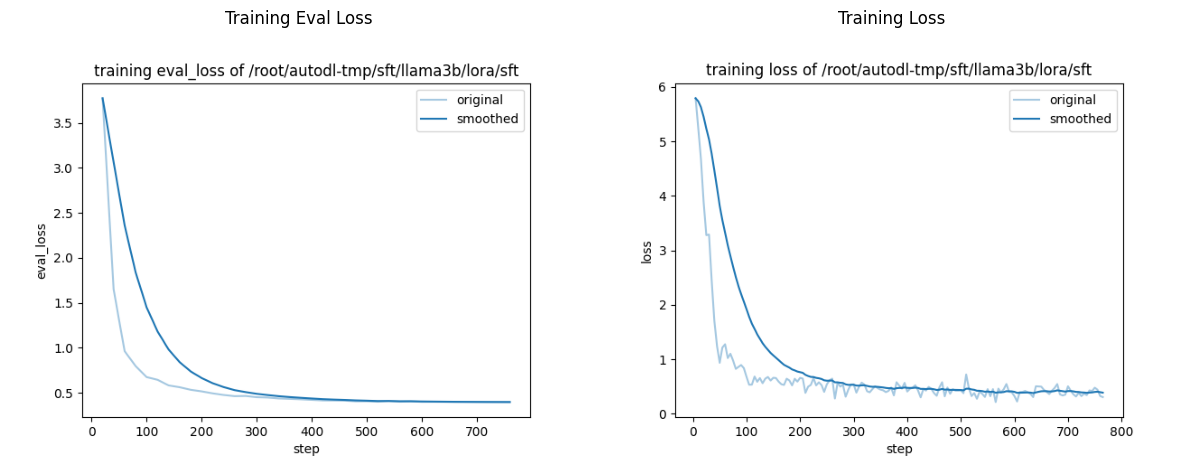

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('/root/autodl-tmp/sft/llama3b/lora/sft/training_eval_loss.png')
img2 = mpimg.imread('/root/autodl-tmp/sft/llama3b/lora/sft/training_loss.png')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  
axs[0].imshow(img1)
axs[0].set_title('Training Eval Loss')
axs[0].axis('off')  

axs[1].imshow(img2)
axs[1].set_title('Training Loss')
axs[1].axis('off')

plt.tight_layout()
plt.show()

### Part 3.3.6 Qwen2.5-7b fine-tuning parameters

In [ ]:
CUDA_VISIBLE_DEVICES=0 llamafactory-cli train \
    --stage sft \
    --do_train \
    --model_name_or_path /root/Qwen2.5-7B-Instruct \
    --dataset seek_train_salary \
    --dataset_dir /root/LLaMA-Factory/data \
    --template qwen \
    --finetuning_type lora \
    --output_dir /root/autodl-tmp/sft/qwen7b/lora/sft \
    --overwrite_cache \
    --overwrite_output_dir \
    --cutoff_len 256 \
    --preprocessing_num_workers 4 \
    --per_device_train_batch_size 1 \
    --per_device_eval_batch_size 1 \
    --gradient_accumulation_steps 8 \
    --lr_scheduler_type cosine \
    --logging_steps 5 \
    --warmup_steps 50 \
    --save_steps 20 \
    --eval_steps 20 \
    --eval_strategy steps \
    --save_strategy steps \
    --load_best_model_at_end \
    --metric_for_best_model eval_loss \
    --greater_is_better False \
    --learning_rate 1e-6 \
    --num_train_epochs 1.0 \
    --val_size 0.2 \
    --plot_loss \
    --fp16

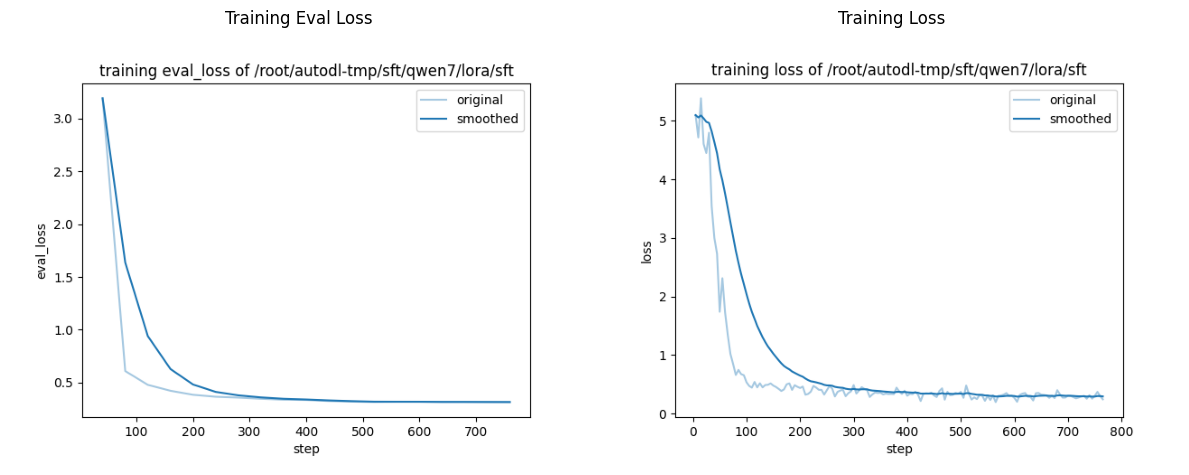

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('/root/autodl-tmp/sft/qwen7/lora/sft/training_eval_loss.png')
img2 = mpimg.imread('/root/autodl-tmp/sft/qwen7/lora/sft/training_loss.png')

fig, axs = plt.subplots(1, 2, figsize=(12, 6))  
axs[0].imshow(img1)
axs[0].set_title('Training Eval Loss')
axs[0].axis('off')  

axs[1].imshow(img2)
axs[1].set_title('Training Loss')
axs[1].axis('off')

plt.tight_layout()
plt.show()

### Part 3.3.7 Chatgpt4.1-mini fine-tuning parameters

Since the fine-tuning port opened by OpenAI has fewer parameters to choose from.  
The parameters I chose are:  
Epochs = 3  
Batch size = 4  
LR multiplier = 1  
Seed = 42  

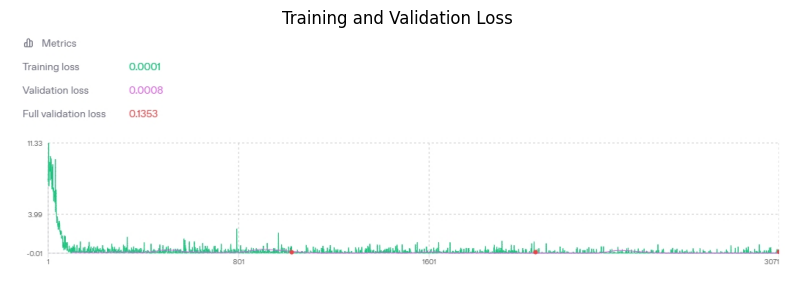

In [11]:
from PIL import Image


img = Image.open('/root/autodl-tmp/1.png')

plt.figure(figsize=(10, 4))
plt.imshow(img)
plt.axis('off')
plt.title('Training and Validation Loss')
plt.show()

## Part 3.4 Ensemble model

In [ ]:
import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, StoppingCriteria, StoppingCriteriaList
import csv
from peft import PeftModel
from bs4 import BeautifulSoup
import re
import os
import gc
import torch


/root/miniconda3/lib/python3.12/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
# load Qwen
model_name_1 = "/root/Qwen2.5-7B-Instruct"
lora_adapter_path_1 = "/root/autodl-tmp/sft/qwen7/lora/sft/"

tokenizer_1 = AutoTokenizer.from_pretrained(model_name_1, trust_remote_code=True)

# load Qwen-7b
model1 = AutoModelForCausalLM.from_pretrained(
    model_name_1,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True
)


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# load Llama
model_name_2 = "/root/autodl-tmp/Llama-3.2-3B-Instruct"
lora_adapter_path_2 = "/root/autodl-tmp/sft/llama3b/lora/sft/"

tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2, trust_remote_code=True)

# load Llama-3b
model2 = AutoModelForCausalLM.from_pretrained(
    model_name_2,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True
)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model2 = PeftModel.from_pretrained(model2, lora_adapter_path_2)


In [ ]:
import json

def read_jsonl(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

In [ ]:
work_questions = read_jsonl("/root/autodl-tmp/data/work_alpaca_test.jsonl")
seniority_questions = read_jsonl("/root/autodl-tmp/data/seniority_alpaca_test.jsonl")
salary_questions = read_jsonl("/root/autodl-tmp/data/salary_alpaca_test.jsonl")

In [ ]:
def build_classification_message(input_text):
    return [
        {"role": "system", "content": "You are an intelligent assistant that can judge the type of user questions. Question types include: salary, work arrangement, seniority."},
        {"role": "user", "content": f"Please determine which type of question (salary/work arrangement/seniority) this is:\n\n{input_text}\n\nPlease only answer with type, no explanation."}
    ]


In [ ]:
def build_salary_answer_message(instruction, input_text):
    return [
        {"role": "system", "content": "You are a salary information extraction assistant. Please extract the salary range from the job description, the structure should be 100-200-AUS-MONTHLY. If the salary is not mentioned, return 0-0-None-None."},
        {"role": "user", "content": f"{instruction}\n\n{input_text}"}
    ]

In [ ]:
def get_model_response(model, tokenizer, messages, max_new_tokens=50):
    input_text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    input_ids = tokenizer(input_text, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **input_ids,
            max_new_tokens=max_new_tokens,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(outputs[0][input_ids["input_ids"].shape[-1]:], skip_special_tokens=True)
    return generated_text.strip()

In [ ]:
shots = """example1：
Job Title: Financial Account - Call Center Agent - Up to 34k
Job Description: Job Opening Financial Account - Call Center Agent - Up to 34k Job Industry Telecommunications Job Type Full-Time Experience Level Entry Level Date Posted 2022-10-27 Job Location Pasig BlvdPasig1000NCRPhilippines Company Information Sapient
 
 Pasig Blvd 
 Cebu, Central Visayas 
 6019 
 Sapient is Philippine-based BPO that provides a range of outsourcing services from consulting services, IT-enabled services, and call center services primarily catering small and medium based enterprises. Job Description Job Responsibilities: Answers phone calls and provides important information/ assistance to clients Checks mail, fax and internet mail to provide customer assistance Communicates with customer on the phone or using written correspondence to take care of concerns Answer participant questions, , as well as talk to participants to achieve full understanding of what critical information are being asked. Job Qualifications What are we looking for? Open to candidates who completed college Open to High School and Senior High School Graduates with BPO experience Excellent to above average English communication skills BPO experience of at least 6 months or have work experience Can do onsite work With in 25km to 35 km Compensation 17500 Compensation Range ₱15,000 - ₱20,000
Location: PH
y_true: 17500-17500-PHP-MONTHLY

example2：
Job Title: Aspiring Call Center Agents - Work from Home - Must be residing in Davao
Job Description: Job Opening Aspiring Call Center Agents - Work from Home - Must be residing in Davao Job Industry Telecommunications Job Type Full-Time Experience Level Entry Level Date Posted 2023-08-09 Job Location - Davao 8000 Davao del Sur Philippines Company Information Neksjob Corporation - We are driven by the innate desire to bring about change by encouraging out of the box solutions to well-worn path challenges at a cost-effective rate. We aim to bridge the gap between countries and cultures, distance and time zones, to bring the world closer through the help of emerging technology. Job Description Responsibilities: Answering incoming calls from customers Sorting out customers’ inquiries or requests Ensuring that customers’ requests are managed in an appropriate and timely manner Developing, organizing, and maintaining accurate files Delivering a high caliber of service in a friendly, confident, and informed manner Job Qualifications Qualifications: • Must be 18 years of age and above • At least high school graduate with diploma/certificate • Willing to work full-time and in shifting schedule (No Part-time) • Good to excellent English communication skills • Computer literate and with good web navigation skills • Available to start ASAP Work At Home Requirements: • Minimum upload speed of 5 MBPS • Minimum download speed of 10 MBPS • Wired connection from modem/router to PC • Conducive workspace away from distractions • Highly stable internet connection with no packet loss Compensation 16000 Compensation Range ₱15,000 - ₱20,000
Location: PH
y_true: 16000-16000-PHP-MONTHLY

example3：
Job Title: Production Staff Required - Afternoon & Night-shift
Job Description: Original Foods Baking Co. is one of New Zealand’s favourite wholesale bakeries.  We have been perfecting the art of good baking for over 30 years, and our products are dangerously good! Proudly New Zealand owned and operated, our donuts, cakes, brownies, muffins, slices, cookie pies and more are sold throughout New Zealand in supermarkets and wholesalers under the Original Foods Baking Co., Goofy and Bite Me brands. We are recruiting for experienced, strong, capable and motivated production staff to work in some of our more physically demanding roles. These roles will suit persons with the following attributes; Experience in a production environment Experience in mundane, repetitive roles Strong and physically fit Reliable, trustworthy, dependable Strong numeracy skills Team-player Please indicate which shift is your preference on application. Days & Hours of Work Monday - Friday Night shift 10.00pm - 6.30am Afternoon shift 2:00pm - 10:30pm You must be double vaccinated and have the right to live and work in New Zealand to apply for this role. Applications will be reviewed as they are received so apply NOW!
Location: NZ
y_true: 0-0-None-None

example4：
Job Title: Payer Analyst
Job Description: The Payer Analyst individual is assigned to the Revenue Cycle Management Product Management Content Intelligence team. The individual finds and analyzes health plans and payor websites for billing related information and enters selected information using a standardized data collection system and is responsible for setting up the website tracking and maintenance of the system that auto-tags relevant information contained in the content.  The individual assures, for each organization targeted that all are found and any relevant URLs and content are  are collected. Primary Duties/Responsibility 1:  Payer Content Research Researching Payer websites for content related to Healthcare Revenue Cycle Management and Billing. (Claims, Authorizations, Remittance Advice) Sign up for relevant email list-serves when available. Take the lead to proactively identify, track and distribute notifications to appropriate audiences to ensure issues are addressed before there is any impact to our customers. Identify new trends that impact the healthcare industry for potential in-scope expansion. Primary Duties/Responsibility 2:  Website Tracking & Maintenance Setup website tracking using “point & click” tools allowing for changes of websites to be identified. Tracking maintenance – resolve any tracking errors that may arise.  Monitor all tracking to ensure the latest versions of URLs/PDFs are input on a routine basis Primary Duties/Responsibility 3:  NLP Tagging Setup & Maintenance Setup the payer information in a Natural Language Processing system that allows for tagging of internal identifiers and content based subscription topics. Maintain payer set up by adding additional alternative labels as needed, i.e. when new tracking is added. Must be able to analyze overall system set-up concept to successfully resolve over/under tagging issues as they arise Primary Duties/Responsibility 4:  Curate Internal Notification & Bulletins Monitor incoming subscriptions and change tracking of payer websites to ensure NLP and Subscription topics are being properly associated with the information. Modify/split content into individual articles building internal “payer notices” to internal subscribers (There’s a lot of reading, copy & pasting.) Must maintain high standard in out-going content to Audiences with proper grammar, spelling and layout of the information. Maintain turn-around time performance standards to ensure timely release of information. Primary Duties/Responsibility 5:  Platform Migration Assist the team in migrating and testing above business processes to a new platform and start performing processes in new system. The ability to take on projects while maintaining current work-load; verbalizing the need for assistance when/if needed. The Payer Content Intelligence Analyst individual requires the ability to read and identify changes that need to be made to existing Claims Edits and Prior Auth policies as well as create internal bulletins based on their interpretation of the content. While the majority of the content is notifying internal teams of the website or subscription changes the written communication needs to be concise and accurate when documenting policy changes. Preferred Qualification/s: The ideal candidate is experienced in healthcare billing  with knowledge of managed care/payor/healthcare insurance companies who understands and has worked with medical policies, prior authorization, or utilization review.  Ability to comprehensively search the internet for payor content and accurate transcribe data to a prepared template is required. The preferred candidate will also have experience setting up NLP, Machine Learning, AI to assist with automatically tagging content. Minimum of 3 years of healthcare billing in an ambulatory or acute setting is required. Experience is other aspects of healthcare technology will also be considered.
Location: PH
y_true: 0-0-None-None

example5：
Job Title:   Solicitor, Restructuring (ID: 2100013K)
Job Description: The DLA Piper team operates across more than 40 countries, but we’re still locally connected. Our Restructuring & Insolvency team work on some of the most complex and interesting matters in the market. We partner with a diverse client base that includes debtors, lenders, government entities, trustees, shareholders, senior executives, as well as distressed debt and asset buyers and investors. We are currently looking for high performing restructuring solicitor with 5 + years’ experience to join the team based in our Melbourne office MAIN DUTIES AND RESPONSIBILITIES First class lawyers, experience and our unrivalled global coverage are just the beginning of what DLA Piper offers. By joining our team you will have the opportunity to work on a range of matters, advising clients on investigations, enforcement, litigation and asset recovery on a multijurisdictional basis. As part of our forward thinking team, you will share a client centric approach and take pride in delivering our clients sector focused advice across key expertise areas such as financial services, energy, resources & mining, retail, property and technology. ABOUT YOU We know talent is more than what's written on paper. It's the energy you bring and the way you work with your team. Your strong communication skills will enable you to develop and maintain high quality relationships with clients.  You will have a mature, confident approach and be highly motivated, thriving in a fast-paced practice. Your organisational skills and ability to manage your own workload, seeking input from team members where needed will support your success. You will receive first class on the job support and training, working with partners including  Lionel Meehan. You will also have access to our DLA Piper Career Academies, an award-winning international development forum designed to cultivate high performance and support your career goals. If you're a high performing restructuring lawyer ready to take the next step in your career at a firm that values you, we want to hear from you. Apply now and be part of our future. ABOUT US DLA Piper is a global law firm with lawyers located in more than 40 countries throughout the Americas, Europe, the Middle East, Africa and Asia Pacific. Our global reach ensures that we can help businesses with their legal needs anywhere in the world. We strive to be the leading global business law firm by delivering quality, service excellence and value to our clients and offering practical and innovative legal solutions to help them succeed. Our clients range from multinational, Global 1000, and Fortune 500 enterprises to emerging companies developing industry-leading technologies, as well as government and public sector bodies. OUR VALUES In everything we do connected with our People, our Clients and our Communities, we live by these values: Be Supportive - we care about others, value diversity and act thoughtfully Be Collaborative - we give, we share and we join in Be Bold - we stand tall and challenge ourselves to think big Be Exceptional - we exceed standards and expectations DIVERSITY AND INCLUSION At DLA Piper, diversity and inclusion underpins how we live our values and everything we do.  We believe that everyone has a voice, and that everyone’s voice counts. We know that the rich diversity across our firm makes us stronger, more innovative and creative, which helps us to better serve our clients and communities. We are committed to providing an inclusive working environment and culture across our global firm, where everyone can bring their authentic self to work. Diversity of perspective, thought, background and culture combine to make us the leading global law firm; that’s why we actively seek to build balanced teams. We welcome the unique contribution that you will bring to our firm and actively encourage applications from all talented people – however your talent is packaged, whatever your background or circumstance and regardless of how you identify. We support anyone with a disability or long term health condition to ensure they have the opportunity to perform at their best. If you have not done so already, please let us know if you require any support so we can make the right adjustments and considerations should they be required. AGILE WORKING We know that people have responsibilities and interests outside of their career and that as a business, we all benefit from working flexibly. That's why we are open to discussing with candidates the different ways in which we are able to support requests for agile working arrangements. PRE-ENGAGEMENT SCREENING In the event that we make an offer to you, and where local legislation permits, we will conduct pre-engagement screening checks that may include but are not limited to your professional and academic qualifications, your eligibility to work in the relevant jurisdiction, any criminal records, your financial stability and references from previous employers.
Location: AUS
y_true: 0-0-None-None

example6：
Job Title: Sanrio Gift Gate 兼職店務員(馬鞍山)
Job Description: Sanrio Gift Gate 兼職店務員(馬鞍山) 工作內容: 負責精品店舖Sanrio Gift Gate的日常運作，提供優質客戶服務，銷售貨品及貨品陳列 要求: 具有關工作經驗優先, 有責任感, 積極主動, 熱誠, 具良好銷售技巧優先 工作時間: 上午10時 至 晚上10時, 每週工作3-5天 ，每更工作6-9小時 工作地點: 馬鞍山Sanrio Gift Gate分店 兼職時薪: $50 - $60 有意應徵者可 (1) 電郵個人履歷至recruitretail@danielco.com.hk 或 (2) 致電招聘熱線2149 8621 或   (3) 招聘whatsapp 6232 3687 或 https://forms.gle/7n1o8yFAfZTxuZkz5 填寫資料 <申請人所提供的資料將予保密及只作招聘用途>
Location: HK
y_true: 50-60-HKD-HOURLY

example7：
Job Title: Key Account Manager
Job Description: This role will contribute to expand our client Indonesia's customer base (B2B) and profit and loss statement by increasing the engagement with current customers and effectively bringing new customers on board. Client Details Our client is a global leader in packaging solutions. Description Contribute to the identification of products within the customer portfolio that demonstrate high market potential, competitiveness, and align with the client manufacturing capabilities. Participate in establishing tactical or strategic partnerships with customers to ensure the long-term supply of the products. Undertake customer research activities. Aid in the development of market insights and analyses for senior stakeholders. Assist in crafting business plans for new products and strategic partnerships. Collaborate with internal cross-functional teams to ensure the successful delivery of these products and fulfil client's commitments to its customers. Manage external stakeholders within the customer organisation in line with stakeholder mapping. Organise business planning events and periodic performance reviews (quarterly, semi-annually, annually) with customers. Facilitate the on boarding process for new customers and arrange visits to client's plants. Manage sales processes between client and customers. Develop monthly sales forecasts in conjunction with the customer. Support joint tactical marketing events with the marketing team or other departments. Profile A D3 degree holder Have minimum 3 years of experience and been at least once in sales or business development role Proficiency in English will be a plus Business Acumen Commercial Awareness: Capable of comprehending and grasping business concepts and strategies. Autonomous: Demonstrated track record of delivering results independently as an individual contributor. Analytic Proficiency : Competent in independently gathering and organising customer data for effective presentations. Previous involvement in customer and competitor research is a plus. Product Development Management of Product Life cycle : Previous experience in participating in the initial phases of product introduction to new customers or launching new products is advantageous. Analytic Thinking : Proficient in collecting customer insights, identifying opportunities, and offering actionable recommendations. Sales Process Effective Key Account Management : Previous involvement in managing the sales process from prospecting to achieving profitable outcomes. Soft Skills Interpersonal Adaptability : Capable of adjusting communication style and approach based on the audience. Skilled at building rapport with stakeholders at various levels. Stakeholder Engagement : Effective collaboration with cross-functional teams and establishing productive relationships with external stakeholders. Self-Motivated : Able to work independently with minimal supervision. Disciplined, proactive, and willing to go the extra mile, including working beyond standard office hours and travelling. Quick Learning Ability: Demonstrated willingness and eagerness to independently seek out information and learn about new businesses, products, and markets. Presentation Proficiency : Strong presentation skills and proficient in using the Microsoft Office suite. Job Offer Exciting career advancement opportunities abound within the company due to its remarkable growth potential. The opportunity to be part of a global company. A chance to significantly influence the commercial decisions of a highly successful enterprise and contribute to the development, execution, and oversight of systems from the outset. Competitive compensation package and bonus. To apply online please click the 'Apply' button below. For a confidential discussion about this role please contact Cheren Filus on +62 21 2958 8838.
Location: ID
y_true: 0-0-None-None

example8：
Job Title: Customer Service Agent With 1 month Call Center Experience
Job Description: Job Opening Customer Service Agent With 1 month Call Center Experience Job Industry Telecommunications Job Type Full-Time Experience Level Associate Date Posted 2023-08-15 Job Location -Baguio2600Baguio CityPhilippines Company Information Neksjob Corporation
 
 - 
 We are driven by the innate desire to bring about change by encouraging out of the box solutions to well-worn path 
challenges at a cost-effective rate. We aim to bridge the gap between countries and cultures, distance and time zones,
to bring the world closer through the help of emerging technology. Job Description Duties/Responsibilities:
Responsible for taking incoming calls or making outgoing calls for a business in a call center. These calls may be for a variety of situations, such as customer service, sales calls, product instructions, and billing inquiries. You may be responsible for taking orders, handling customer complaints, and answering questions from callers.
Why pick us?
Competitive Salary
Exciting Performance Bonuses & Account Specific Allowances
Career Advancement Opportunities
Promote Within the Company
Comprehensive Healthcare Benefits Job Qualifications What are we looking for?
Good to excellent communication skills 
At least 1 month Call Center Experience
Amenable to Work On-site Compensation 16000 Compensation Range ₱15,000 - ₱20,000 Inquire Apply for Job 
 Cancel
Location: PH
y_true: 16000-16000-PHP-MONTHLY

example9：
Job Title: ASAP - HR AND ADMIN ASSISTANT
Job Description: Job Opening ASAP - HR AND ADMIN ASSISTANT Job Industry Recreational Facilities Services Job Type Full-Time Experience Level Entry Level Date Posted 2023-10-25 Job Location Makati City Makati 1226 Metro Manila Philippines Company Information I-TECH DIGITAL PRODUCTIONS, INC Makati City Palanan, Makati City 1226 Interested applicants may email their resumes. Do not attach your resume here, just send it to claire2023.itechdigital@gmail.com Job Description Conducting interviews, recruiting, and vetting new staff. Arranging training sessions with all new hires and refresher workshops for existing employees. Assisting managers with staff requirements. Identifying and addressing employee requirements regarding performance issues, training, and career growth. Performing various administrative tasks and accurately processing paperwork. Counseling staff on HR policies, practices, and procedures. Job Qualifications *Bachelor’s degree in Human Resources. *Minimum 2 years of relevant experience in human resources. *Prepare HR documents, like employment contracts and new hire guides. *Answer employees queries about HR-related issues. *Assist payroll department by providing relevant employee information (e.g. leaves of absence, sick days and work schedules). *Ensures that policies are fully implemented and performance management and other such staff issues are addressed appropriately in line with the labour law and in a timely manner. *Excellent verbal and written communication skills. *Strong interpersonal skills and proven ability to handle diverse sources of information in a confidential, sensitive manner with due care, respect and discretion and absolute confidentiality *Full understanding of HR functions esp. IR process. *Additional training/certification in Payroll Management – may be advantageous but not required. *Willing to work in Makati City * Can start ASAP / Job types: FULL TIME. Compensation 17500 Compensation Range ₱15,000 - ₱20,000 Number of Job Opening 2 Highest Education Attainment College Graduate
Location: PH
y_true: 17500-17500-PHP-MONTHLY

example10：
Job Title: Brand Ambassador
Job Description: We have a super exciting opportunity in Queenstown to work as a brand ambassador for a new spirit company hitting our shores. For this campaign we are recruiting brand ambassadors, who confident, enjoy going up to strangers and get excited. Due to the nature of the client, all candidates will be interviewed. Reporting to our Manager, this role is all about sales & giving out merchandise! Providing outstanding customer service in-store Driving in-store sales Working closely within a team dynamic Working closely with sales reps Own Transport Can start immediately To be successful in the role, you will: Be a sales focused dynamo and love bar, retail sales Be positive, friendly and approachable Share our passion for spirits Be a genuine people person – you are confident and thrive on making new connections and comfortable being around all walks of life Reliable - you turn up to work and on time and have a reliable form of transport to and from work Well-presented Be able to work independently and confidently in a sole charge capacity A team player and enjoy collaborating with your team Willing to learn and to teach others Have a car Mileage and Travel will be reimbursed if over 20KMS Applicants must: Be 25 years or older Can commit to 20 hours per week across 6 weeks Must be able to work as an Independent Contractor within New Zealand Campaign kicks off 1st August Have previous retail sales experience and a proven track record and ability to generate sales. So, what are you waiting for? Join a team of passionate people who push boundaries and create memorable experiences. To apply for this role you need to have the right to work in New Zealand as an Independent Contractor. Job Type: Freelance Contract length: Pay: From $32.00 per hour Schedule: Rotating roster Expected Start Date: ASAP
Location: NZ
y_true: 32-32-NZD-HOURLY'"""

In [ ]:
results = []
correct = 0
for i, q in enumerate(seniority_questions):
    instruction = q['instruction']
    input_text = q['input']
    true_output = q['output']

    match = re.search(r'^(.*?y_true.*?:)', instruction, re.DOTALL)
    if not match:
        print(f"No y_true found in instruction: {instruction}")
        continue

    # classify question type
    classify_messages = build_classification_message(match.group(1))
    qwen_type_response = get_model_response(model1, tokenizer_1, classify_messages)

    # not salary
    if "work" in qwen_type_response.lower():
        direct_answer_messages = [
            {"role": "user", "content": f"{instruction}\n\n{input_text}"}
        ]
        qwen_direct_answer = get_model_response(model1, tokenizer_1, direct_answer_messages)

        if qwen_direct_answer == str(true_output):
            correct += 1

        results.append({
            "index": i,  
            "predicted": qwen_direct_answer,
            "true_label": str(true_output)
        })
    elif "salary" in qwen_type_response.lower():
        direct_answer_messages = [
            {"role": "user", "content": f"{instruction}\n{shots}\n{input_text}"}
        ]
        qwen_direct_answer = get_model_response(model1, tokenizer_1, direct_answer_messages)

        if qwen_direct_answer == str(true_output):
            correct += 1

        results.append({
            "index": i,  
            "predicted": qwen_direct_answer,
            "true_label": str(true_output)
        })
    # seninority question
    else:
        messages = [
            {"role": "user", "content": f"{instruction}\n\n{input_text}"}
        ]
        # for salary question, we use LoRA adapter
        if not hasattr(model1, 'peft_config'):
            model1 = PeftModel.from_pretrained(model1, lora_adapter_path_1)
        llama_answer = get_model_response(model2, tokenizer_2, messages)

        # Use LLaMA verifies Qwen's answer
        check_prompt = (
            f'question: {instruction + shots+input_text}\n'
            f'Llama answer is: {llama_answer}\n'
            f'Do you think this answer is correct? Please answer "yes" or "no" only.'
        )
        messages2 = [
            {"role": "user", "content": check_prompt}
        ]
        validation = get_model_response(model1, tokenizer_1, messages2)
        # print(validation)
        if "no" in validation:
            qwen_answer = get_model_response(model1, tokenizer_1, messages)
            feedback_prompt = f"The Qwen model think the correct answer is: {qwen_answer}. \nRefer to it but don't believe it."
            messages3 = [
                {"role": "user", "content": f"{instruction}\n\n{input_text}\n\n{feedback_prompt}"}
            ]
            final_answer = get_model_response(model2, tokenizer_2, messages3)
            if final_answer == true_output:
                correct += 1
            results.append({
                "index": 'a',  
                "predicted": final_answer,
                "true_label": str(true_output)
            })
        else:
            results.append({
                "index": i,  
                "predicted": llama_answer,
                "true_label": str(true_output)
            })
            if llama_answer == true_output:
                correct += 1

    number=i+1
    if (i + 1) % 50 == 0:
        checkpoint_df = pd.DataFrame(results)
        directory = "combine"
        filename = f"{directory}/combine-predictions_senioirty1.csv"

        os.makedirs(directory, exist_ok=True)
        checkpoint_df.to_csv(filename, index=False)
        print(f"{i+1}, save result to:{filename}")
filename = f"{directory}/combine-predictions_senioirty1.csv"
final_df = pd.DataFrame(results)
final_df.to_csv(filename, index=False)


50, save result to:combine/combine-predictions_senioirty1.csv
100, save result to:combine/combine-predictions_senioirty1.csv
150, save result to:combine/combine-predictions_senioirty1.csv
200, save result to:combine/combine-predictions_senioirty1.csv
250, save result to:combine/combine-predictions_senioirty1.csv
300, save result to:combine/combine-predictions_senioirty1.csv
350, save result to:combine/combine-predictions_senioirty1.csv
400, save result to:combine/combine-predictions_senioirty1.csv
450, save result to:combine/combine-predictions_senioirty1.csv
500, save result to:combine/combine-predictions_senioirty1.csv
550, save result to:combine/combine-predictions_senioirty1.csv
600, save result to:combine/combine-predictions_senioirty1.csv
650, save result to:combine/combine-predictions_senioirty1.csv


In [ ]:
correct

336

In [ ]:
accuracy=correct/number

In [ ]:
accuracy

0.4876632801161103

# Part 4 results

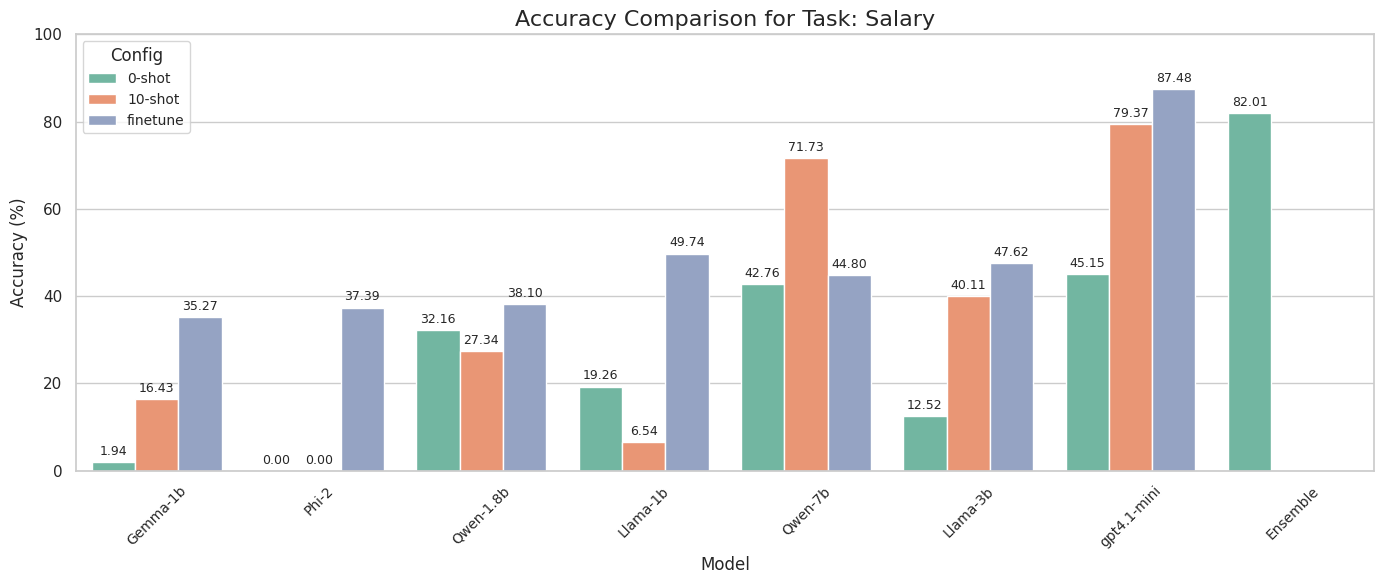

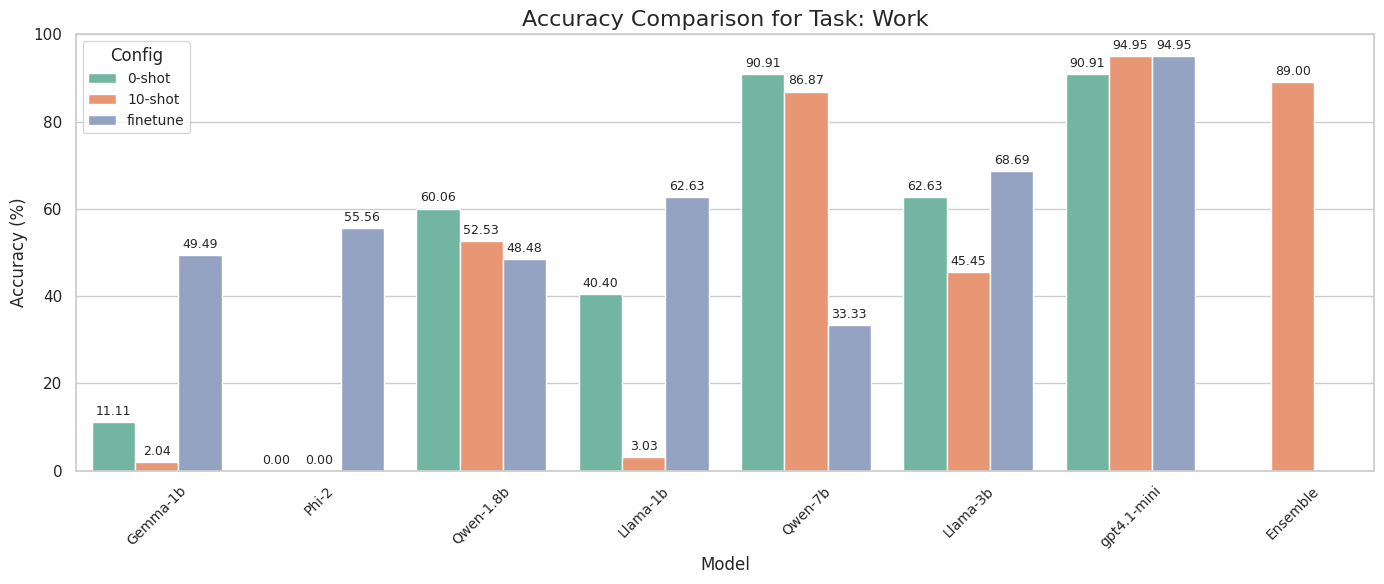

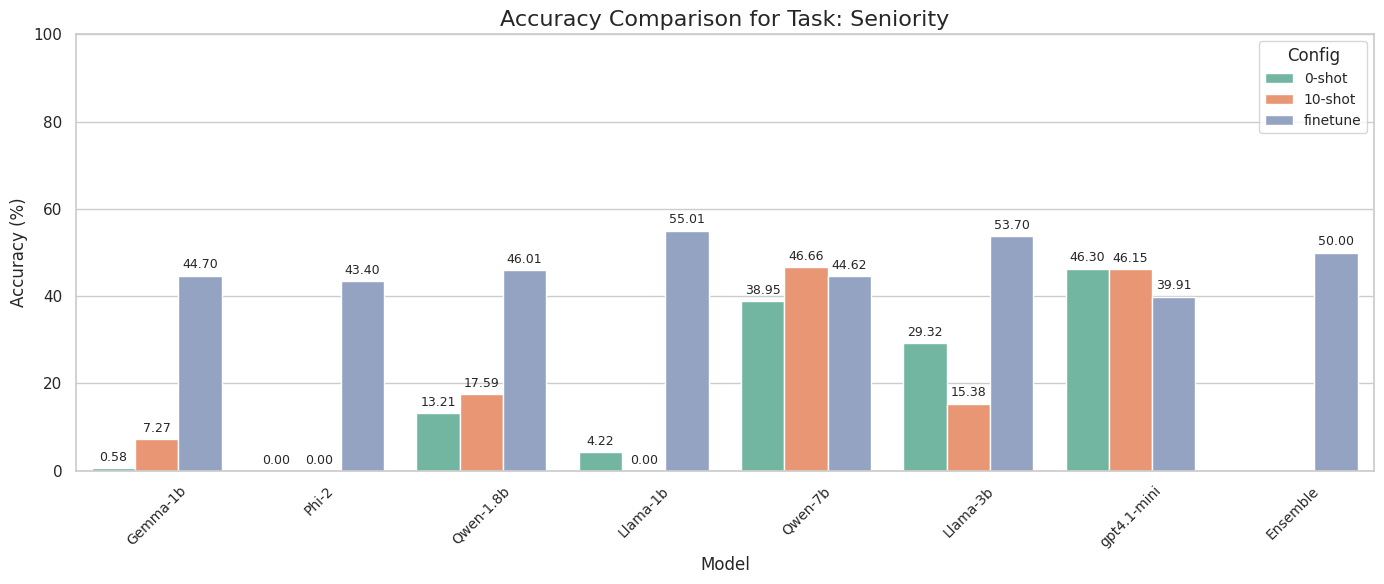

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'Model': [
        'Gemma-1b', 'Gemma-1b', 'Gemma-1b',
        'Phi-2', 'Phi-2', 'Phi-2',
        'Qwen-1.8b', 'Qwen-1.8b', 'Qwen-1.8b',
        'Llama-1b', 'Llama-1b', 'Llama-1b',
        'Qwen-7b', 'Qwen-7b', 'Qwen-7b',
        'Llama-3b', 'Llama-3b', 'Llama-3b',
        'gpt4.1-mini', 'gpt4.1-mini', 'gpt4.1-mini',
        'Ensemble', 'Ensemble', 'Ensemble'
    ] * 3,

    'Task': ['salary'] * 24 + ['work'] * 24 + ['seniority'] * 24,

    'Config': ['0-shot', '10-shot', 'finetune'] * 24,

    'Accuracy': [
        1.94, 16.43, 35.27,
        0, 0, 37.39,
        32.16, 27.34, 38.10,
        19.26, 6.54, 49.74,
        42.76, 71.73, 44.80,
        12.52, 40.11, 47.62,
        45.15, 79.37, 87.48,
        82.01, None, None,
        11.11, 2.04, 49.49,
        0, 0, 55.56,
        60.06, 52.53, 48.48,
        40.40, 3.03, 62.63,
        90.91, 86.87, 33.33,
        62.63, 45.45, 68.69,
        90.91, 94.95, 94.95,
        None, 89.00, None,
        0.58, 7.27, 44.70,
        0, 0, 43.40,
        13.21, 17.59, 46.01,
        4.22, 0, 55.01,
        38.95, 46.66, 44.62,
        29.32, 15.38, 53.70,
        46.30, 46.15, 39.91,
        None, None, 50.00
    ]
}

df = pd.DataFrame(data)
df = df.dropna() 


custom_palette = sns.color_palette("Set2")[:3]


tasks = df['Task'].unique()

for task in tasks:
    plt.figure(figsize=(14, 6))
    subset = df[df['Task'] == task]
    ax = sns.barplot(x='Model', y='Accuracy', hue='Config', data=subset, palette=custom_palette)
    plt.title(f'Accuracy Comparison for Task: {task.capitalize()}', fontsize=16)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.ylim(0, 100)
    plt.legend(title='Config', fontsize=10, title_fontsize=12)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

    plt.tight_layout()
    plt.show()


# Part 5. Discussion

The detailed analysis is reflected in the report. Here we will only briefly analyze our integrated model.  

Our ensemble model is close to the fine-tuned version of chatgpt4.1-mini in the judgment accuracy of salary and work arrangement, and exceeds the fine-tuned version of chatgpt4.1-mini in seniority. If compared with the native version of chatgpt4.1-mini, we have surpassed it in both seniority and salary.